In [ ]:
import polars as pl
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
import joblib
import matplotlib.pyplot as plt

In [ ]:
df = pl.read_parquet("train_data/train.parquet")

to_drop = [
    # Feature 1: Frequency
    'feat1_customer_item_freq',
    # Feature 2: Recency Decay
    'feat2_type_affinity', 
    # Feature 3: Urgency (Window-Based)
    'feat3_urgency_score',
    # Feature 4: Popularity
    'feat4_pop_30d_log', 'feat4_pop_category_rank',
    # Feature 5: Baby Age Alignment
    'feat5_score_age_end_hist', 
    # Feature 6: Price Compatibility
    'feat6_price_compatibility',
    # Feature 7: Brand Loyalty
    'feat7_user_brand_affinity', 'feat7_brand_rank_inv',
    # Feature 8: Co-purchase
    'feat8_co_purchase_count', 'feat8_co_purchase_sum',
]
df = df.drop(to_drop)

feature_cols = [
    # Feature 2: Recency Decay
    'feat2_brand_affinity',

    # Feature 3: Urgency (Window-Based)
    'feat3_is_in_window',

    # Feature 4: Popularity
    'feat4_pop_global_rank', 'feat4_pop_trend',

    # Feature 5: Baby Age Alignment
    'feat5_score_age_midpoint',
    
    # Feature 6: Price Compatibility
    'feat6_is_above_user_capacity',

    # Feature 7: Brand Loyalty
    'feat7_brand_repeat_rate',

    # Feature 8: Co-purchase
    'feat8_co_purchase_max',
]

target_col = 'Y'
X = df.select(feature_cols).to_pandas()
y = df.select(target_col).to_pandas().values.ravel()

print(f"Training shape: {X.shape}")
print(f"Positive Rate: {y.mean():.4f}")

Training shape: (29154317, 19)
Positive Rate: 0.0999


In [ ]:
# Load dữ liệu nhỏ để đánh giá nhanh
inference_small = pl.read_parquet("train_data/inference_final_small.parquet")

gt_small = joblib.load("train_data/groundtruth_small.pkl")
gt_small = {str(k): [str(item) for item in v] for k, v in gt_small.items()}

# Lấy danh sách 15000 customers từ inference_small
inference_customers = inference_small.select("customer_id").unique()["customer_id"].to_list()

# Filter purchase_df chỉ lấy 15000 customers này
purchase_df = pl.scan_parquet("processed_data/processed_purchase.parquet").filter(
    pl.col("customer_id").is_in(inference_customers)
).collect()

hist_df = purchase_df.group_by("customer_id").agg(pl.col("item_id").alias("item_ids"))
hist = {str(row["customer_id"]): [str(iid) for iid in row["item_ids"]] 
        for row in hist_df.iter_rows(named=True)}

print(f"Loaded: {len(inference_small)} inference rows, {len(gt_small)} gt customers, {len(hist)} hist customers")

Loaded: 1450359 inference rows, 15000 gt customers, 15000 hist customers


In [ ]:
# Hàm tính precision@10
def compute_precision_at_k(model, inference_df, gt_dict, hist_dict, features, K=10):
    X_inf = inference_df.select(features).to_pandas()
    y_proba = model.predict_proba(X_inf)[:,1]
    df_pred = inference_df.with_columns(pl.Series("score", y_proba))
    
    top_pred = (df_pred.sort(["customer_id", "score"], descending=[False, True])
                .group_by("customer_id").agg(pl.col("item_id").head(K)))
    
    pred_dict = {str(row["customer_id"]): [str(i) for i in row["item_id"]] 
                 for row in top_pred.iter_rows(named=True)}
    
    precisions = []
    for user in gt_dict:
        if user not in hist_dict or user not in pred_dict:
            continue
        relevant = set(gt_dict[user])
        hits = len(set(pred_dict[user][:K]) & relevant)
        precisions.append(hits / K)
    
    return np.mean(precisions) if precisions else 0.0

In [ ]:
model = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler(with_mean=False)),  # with_mean=False cho sparse data
    ('logreg', LogisticRegression(
        max_iter=1000,
        random_state=42, 
        solver='saga',
        class_weight='balanced', 
        n_jobs=-1,
        penalty = "l1",
        verbose=2,
    ))
])


model.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


convergence after 12 epochs took 352 seconds


,steps,"[('imputer', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,missing_values,nan
,strategy,'constant'
,fill_value,0
,copy,True
,add_indicator,False
,keep_empty_features,False
,copy,True


In [ ]:
# Đánh giá chi tiết model
y_pred_best = model.predict_proba(X)[:,1]
best_train_auc = roc_auc_score(y, y_pred_best)
best_precision = compute_precision_at_k(model, inference_small, gt_small, hist, feature_cols, K=10)

print(f"\nModel Performance:")
print(f"  Train AUC: {best_train_auc:.4f}")
print(f"  Precision@10: {best_precision:.4f}")
print("="*70)

# Lưu model
joblib.dump(model, 'train_data/model.pkl')
print("\n✓ Model saved to train_data/model.pkl")


BEST PARAMETERS FOUND

Best Model Performance:
  Train AUC: 0.7523
  Precision@10: 0.0534

✓ Best model saved to train_data/model_tuned.pkl


# =============================================================================
# 3. FEATURE IMPORTANCE ANALYSIS
# =============================================================================

In [ ]:
# Phân tích feature importance từ coefficients
coefficients = model.named_steps['logreg'].coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n" + "="*70)
print("TOP 15 MOST IMPORTANT FEATURES")
print("="*70)
print(feature_importance.head(20).to_string(index=False))

print("\n" + "="*70)
print("TOP 5 POSITIVE IMPACT (Tăng xác suất mua)")
print("="*70)
print(feature_importance.nlargest(5, 'coefficient')[['feature', 'coefficient']].to_string(index=False))

print("\n" + "="*70)
print("TOP 5 NEGATIVE IMPACT (Giảm xác suất mua)")
print("="*70)
print(feature_importance.nsmallest(5, 'coefficient')[['feature', 'coefficient']].to_string(index=False))


TOP 15 MOST IMPORTANT FEATURES
                     feature  coefficient  abs_coefficient
    feat5_score_age_midpoint     1.524479         1.524479
    feat5_score_age_end_hist    -1.498205         1.498205
           feat4_pop_30d_log    -0.660164         0.660164
             feat4_pop_trend     0.584350         0.584350
     feat8_co_purchase_count    -0.552357         0.552357
        feat7_brand_rank_inv    -0.357579         0.357579
     feat4_pop_category_rank    -0.331352         0.331352
       feat4_pop_global_rank     0.203097         0.203097
          feat3_is_in_window     0.185216         0.185216
       feat8_co_purchase_sum     0.174011         0.174011
       feat8_co_purchase_max     0.171615         0.171615
        feat2_brand_affinity     0.166101         0.166101
     feat7_brand_repeat_rate     0.057787         0.057787
         feat2_type_affinity    -0.054356         0.054356
feat6_is_above_user_capacity     0.047483         0.047483
         feat3_urgency_s

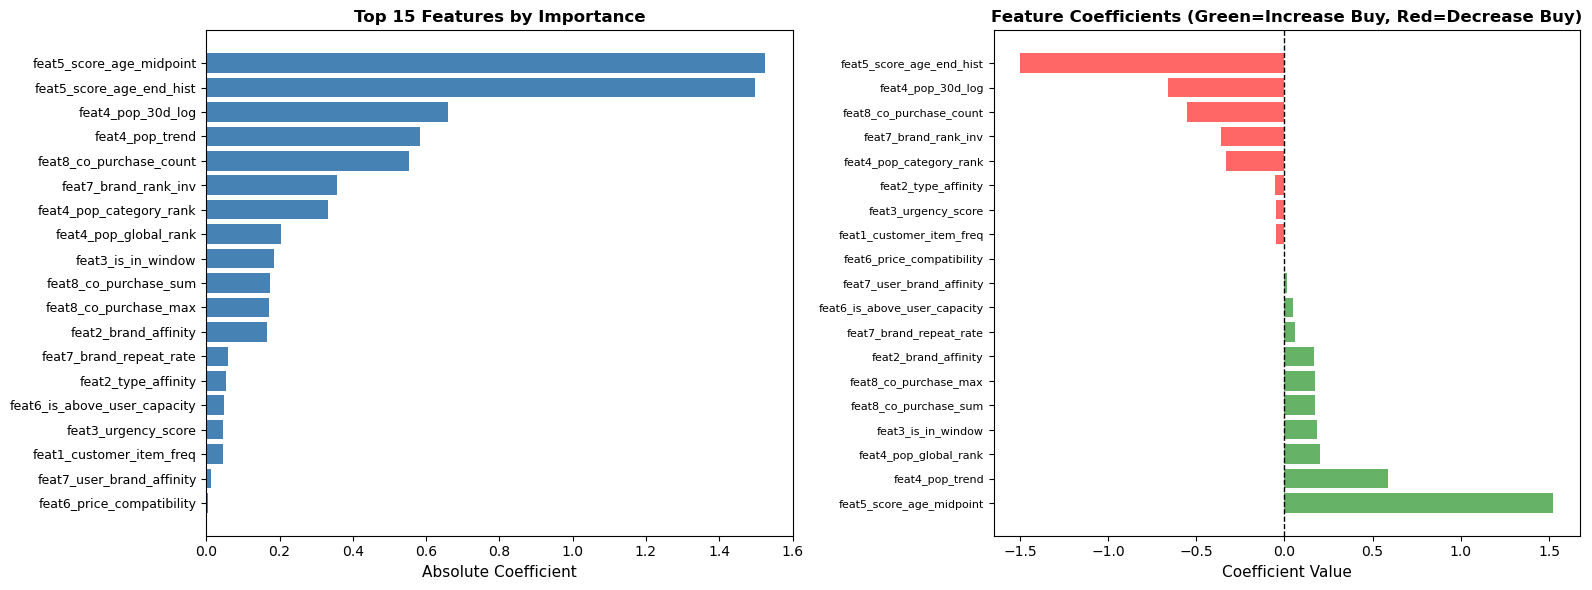

In [11]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top features by absolute value
top_features = feature_importance.head(20)
axes[0].barh(range(len(top_features)), top_features['abs_coefficient'].values, color='steelblue')
axes[0].set_yticks(range(len(top_features)))
axes[0].set_yticklabels(top_features['feature'].values, fontsize=9)
axes[0].set_xlabel('Absolute Coefficient', fontsize=11)
axes[0].set_title('Top 15 Features by Importance', fontsize=12, fontweight='bold')
axes[0].invert_yaxis()

# All features by actual coefficient (positive/negative)
sorted_by_coef = feature_importance.sort_values('coefficient')
colors = ['red' if x < 0 else 'green' for x in sorted_by_coef['coefficient']]
axes[1].barh(range(len(sorted_by_coef)), sorted_by_coef['coefficient'].values, color=colors, alpha=0.6)
axes[1].set_yticks(range(len(sorted_by_coef)))
axes[1].set_yticklabels(sorted_by_coef['feature'].values, fontsize=8)
axes[1].set_xlabel('Coefficient Value', fontsize=11)
axes[1].set_title('Feature Coefficients (Green=Increase Buy, Red=Decrease Buy)', fontsize=12, fontweight='bold')
axes[1].axvline(x=0, color='black', linestyle='--', linewidth=1)
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

# =============================================================================
# 4. PREDICTION DISTRIBUTION ANALYSIS
# =============================================================================

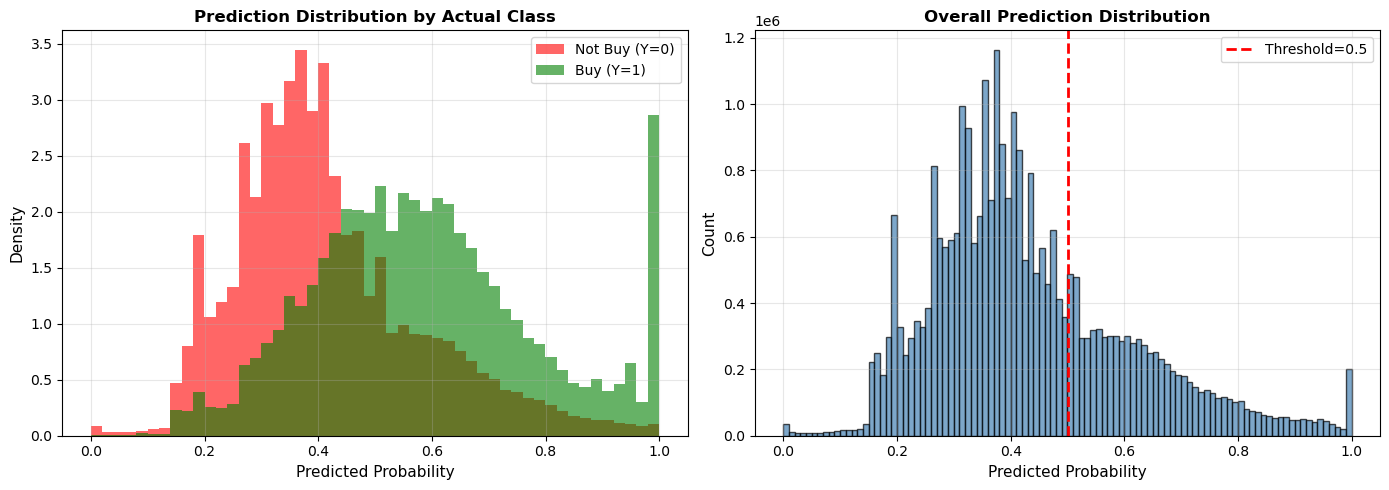


Prediction Statistics:
  Mean: 0.4328
  Median: 0.3987
  Std: 0.1758
  Min: 0.0000
  Max: 0.9997


In [ ]:
# Phân tích distribution của predicted probabilities
y_pred_proba = model.predict_proba(X)[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram cho class 0 và 1
axes[0].hist(y_pred_proba[y==0], bins=50, alpha=0.6, label='Not Buy (Y=0)', color='red', density=True)
axes[0].hist(y_pred_proba[y==1], bins=50, alpha=0.6, label='Buy (Y=1)', color='green', density=True)
axes[0].set_xlabel('Predicted Probability', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Prediction Distribution by Actual Class', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Overall distribution
axes[1].hist(y_pred_proba, bins=100, color='steelblue', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Probability', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Overall Prediction Distribution', fontsize=12, fontweight='bold')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold=0.5')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
print(f"\nPrediction Statistics:")
print(f"  Mean: {y_pred_proba.mean():.4f}")
print(f"  Median: {np.median(y_pred_proba):.4f}")
print(f"  Std: {y_pred_proba.std():.4f}")
print(f"  Min: {y_pred_proba.min():.4f}")
print(f"  Max: {y_pred_proba.max():.4f}")